In [1]:
%matplotlib inline

In [2]:
import keras
from keras.models import Model
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Input, Activation, add
from keras import regularizers

from keras.models import load_model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import os
import glob
import time
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [20]:
driving_data = "collects/run_03_14_23_03/run_03_14_23_03.csv"
parent_dir = "collects/run_03_14_23_03/"

This notebook will train an implementation of Nvidia's PilotNet using TensorFlow/Keras. As an exercise you should modify some or all of the following and compare against the baseline implementation here.

* Drop out probability
* Number of epochs  
* Samples per epoch  
* Batch size         
* Learning rate
* Model layers, outputs: e.g., add regularization, or speed prediction
* Image size (cropped or scaled)
* Image augmentation


Some comparison metrics:

* Can you drive faster than the baseline?
* Do you require less data to train? More?
* Model generalization:
    * Can your model be used on a different car? 
    * Can you slightly change the angle of the front camera at inference time?
    * Does the presence of people or lighting variations affect your model's performance?

In [ ]:
imgs   = []
ngls   = []
speeds = []
lines  = 0
with open(driving_data) as fh:
    for line in fh:
        lines = lines + 1
        l = line.split(',')
        
        speed = l[2]
        speed = float(speed)
        
        # filter out data when the car is stopped
        if np.isclose(speed, 0.):
            continue
        
        speeds.append(speed)
        
        img = l[0]
        imgs.append(parent_dir + img)
       
        ngl = l[1]
        ngl = float(ngl)
        ngls.append(ngl)
print("total data", lines)

In [ ]:
print(len(imgs), len(ngls), len(speeds))

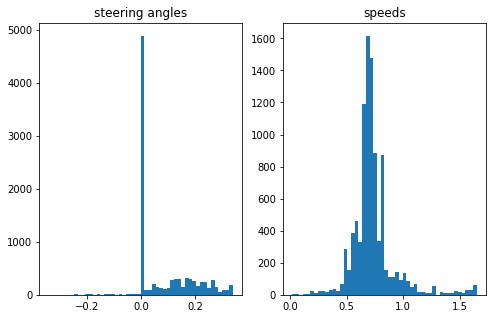

In [23]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(ngls, bins=50);
ax[1].hist(speeds, bins=50);
ax[0].set_title("steering angles")
ax[1].set_title("speeds")
fig.set_size_inches(8,5);

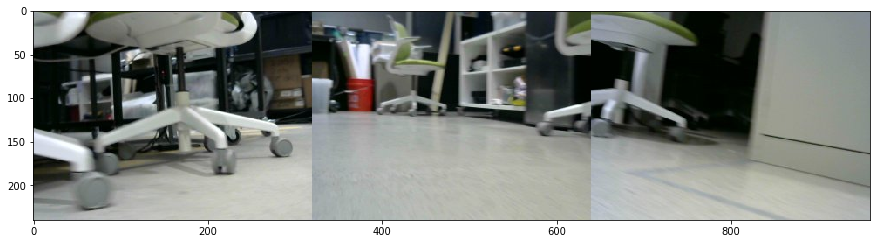

In [31]:
random_id = np.random.randint(0, len(imgs)-1)

img = cv.imread(imgs[random_id], cv.IMREAD_COLOR)

rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(rgb)
fig.set_size_inches(15,5);

In [33]:
def split_lcr(image, width=320, height=240):
    left   = image[0:height, 0:width, :]
    center = image[0:height, width:(width*2), :]
    right  = image[0:height, (width*2):(width*3), :]
    return (left,center,right)

In [41]:
def pilotnet_crop(image):
    """assumes 320x240 input, resizes to 200x66"""
    # rows:    (240 - 66) / 2 == 87
    # columns: (320 - 200) /2 == 60 
    return image[87:-87, 60:-60] 

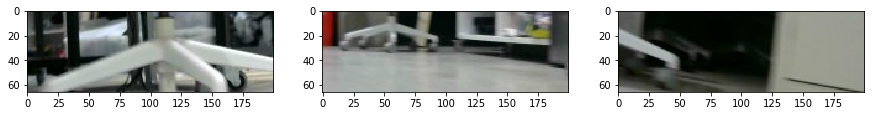

In [42]:
fig, ax = plt.subplots(ncols=3)
l,c,r = split_lcr(rgb)
l = pilotnet_crop(l)
c = pilotnet_crop(c)
r = pilotnet_crop(r)
ax[0].imshow(l)
ax[1].imshow(c)
ax[2].imshow(r)
fig.set_size_inches(15,5);

In [32]:
TEST_SIZE_FRACTION = 0.15
SEED = 56709 #awoo

X_train, X_valid, y_train, y_valid = train_test_split(
    imgs, 
    ngls, 
    test_size=TEST_SIZE_FRACTION, 
    shuffle=False
)
#,random_state=SEED)

print(len(X_train), len(X_valid))

(8105, 1431)


In [43]:
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

def build_model(dropout_rate=0.5):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE)) #normalize the data
    model.add(Conv2D(24, (5,5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(36, (5,5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5,5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (3,3), activation='elu'))
    model.add(Conv2D(64, (3,3), activation='elu'))
    model.add(Dropout(dropout_rate)) 
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    model.summary() # prints out the model description
    return model

In [44]:
model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
__________

In [45]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr=1.0e-4))

In [46]:
checkpoint = ModelCheckpoint('pilotnet-RACECAR-{epoch:03d}.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=False,
                             mode='auto')

In [54]:
OFFSET_STEERING_ANGLE = 0.2 # NOTE: use two values if the left/right camera angles are not symmetric

def batch_generator(image_paths, steering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(len(image_paths)):
            
            lcr_image = cv.imread(image_paths[index])
            l,c,r = split_lcr(lcr_image)
            l = pilotnet_crop(l)
            c = pilotnet_crop(c)
            r = pilotnet_crop(r)
            
            ##############################
            ## TODO add augmentation   ###
            ##############################
            
            groundtruth_steering_angle = steering_angles[index]
            
            if is_training:
                dice = np.random.rand()
                # choose left
                if dice < 0.2:
                    images[i] = l
                    steers[i] = groundtruth_steering_angle - OFFSET_STEERING_ANGLE
                # choose center (60% of the time)
                elif dice < 0.8:
                    images[i] = c
                    steers[i] = groundtruth_steering_angle
                else:
                    images[i] = r
                    steers[i] = groundtruth_steering_angle + OFFSET_STEERING_ANGLE
            else: #only validate with center images (why? no real reason)
                images[i] = c
                steers[i] = groundtruth_steering_angle
            
            i += 1
            if i == batch_size:
                break
        yield images, steers

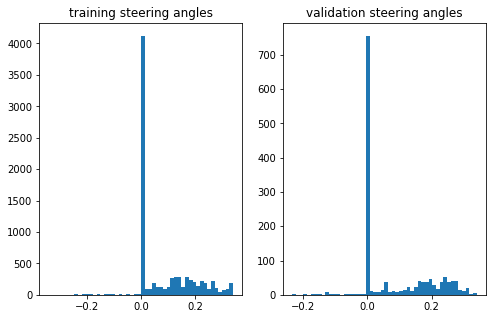

In [49]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(y_train, bins=50);
ax[0].set_title("training steering angles")
ax[1].hist(y_valid, bins=50);
ax[1].set_title("validation steering angles")
fig.set_size_inches(8,5);

You might want to grab more of the image area and shrink it down (instead of just cropping the center of the image out):

```python
cv.resize(crop,(0,0), fx=0.4, fy=0.4, interpolation=cv.INTER_AREA )
```

In [55]:
BATCH_SIZE=20
model.fit_generator(generator=batch_generator(X_train, y_train, batch_size=BATCH_SIZE, is_training=True),
                    steps_per_epoch=2000,
                    epochs=10,
                    validation_data=batch_generator(X_valid, y_valid, batch_size=BATCH_SIZE, is_training=False),
                    # https://stackoverflow.com/a/45944225
                    validation_steps=len(X_valid) // BATCH_SIZE,
                    callbacks=[checkpoint],
                    verbose=1);

Epoch 1/10
2000/2000 [==============================] - 59s - loss: 0.0157 - val_loss: 0.0082
Epoch 2/10
2000/2000 [==============================] - 58s - loss: 0.0119 - val_loss: 0.0081
Epoch 3/10
2000/2000 [==============================] - 58s - loss: 0.0104 - val_loss: 0.0073
Epoch 4/10
2000/2000 [==============================] - 58s - loss: 0.0094 - val_loss: 0.0069
Epoch 5/10
2000/2000 [==============================] - 58s - loss: 0.0087 - val_loss: 0.0081
Epoch 6/10
2000/2000 [==============================] - 58s - loss: 0.0083 - val_loss: 0.0072
Epoch 7/10
2000/2000 [==============================] - 58s - loss: 0.0078 - val_loss: 0.0075
Epoch 8/10
2000/2000 [==============================] - 61s - loss: 0.0075 - val_loss: 0.0064
Epoch 9/10
2000/2000 [==============================] - 60s - loss: 0.0072 - val_loss: 0.0066
Epoch 10/10
2000/2000 [==============================] - 60s - loss: 0.0069 - val_loss: 0.0062
